In [1]:
#@title Imports + defaults settings.
#%load_ext autoreload
#%autoreload 2

import haiku as hk
import jax
import jax.numpy as jnp
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import optax
import os
import warnings
import importlib

warnings.filterwarnings("ignore")

try:
    from google.colab import files
    _ON_COLAB = True
except:
    _ON_COLAB = False

import rnn_utils
import bandits
import disrnn
import hybrnn
import plotting
import rat_data

from scipy.io import loadmat


In [2]:
#@title Set up environment
env_contingencies = [0.9,0.9] # probability of reward in the likely reward side
env_flip_freq = [30,60,90] # contingency flip frequencies
n_actions = 2
#environment = bandits.EnvironmentBanditsFlipsFreq(block_flip_freq=env_flip_freq, reward_probs=env_contingencies) #, predif_sequence = [2,1,0,1,0,0,0,1,1])
environment = bandits.EnvironmentBanditsFlipsFreq(block_flip_freq=env_flip_freq, reward_probs=env_contingencies)

In [ ]:
#@title Set up Agent
gen_alpha = 0.6  # learning rate
gen_beta = 3 # inverse temperature
gen_gamma = 0.0 # forgeting rate
gen_tau = 0 # preservation bias
agent = bandits.AgentQ(alpha=gen_alpha, beta=gen_beta, forgetting_rate=gen_gamma, perseveration_bias=gen_tau)

In [75]:
#@title Set up environment
env_contingencies = [0.9,0.9] # probability of reward in the likely reward side
env_flip_freq = [30,60,90] # contingency flip frequencies
n_actions = 2
#environment = bandits.EnvironmentBanditsFlipsFreq(block_flip_freq=env_flip_freq, reward_probs=env_contingencies) #, predif_sequence = [2,1,0,1,0,0,0,1,1])
environment = bandits.EnvironmentBanditsFlipsFreq(block_flip_freq=env_flip_freq, reward_probs=env_contingencies)

In [ ]:
#@title Set up the RNN (GRU) Model
n_hidden = 1  #@param
def make_gru():
  model = hk.DeepRNN(
      [hk.GRU(n_hidden), hk.Linear(output_size=2)]
  )
  return model

In [28]:
#@title Compute log-likelihood
def compute_log_likelihood(dataset, model_fun, params):

  xs, actual_choices = next(dataset)
  n_trials_per_session, n_sessions = actual_choices.shape[:2]
  model_outputs, model_states = rnn_utils.eval_model(model_fun, params, xs)

  predicted_log_choice_probabilities = np.array(jax.nn.log_softmax(model_outputs[:, :, :2]))

  log_likelihood = 0
  n = 0  # Total number of trials across sessions.
  for sess_i in range(n_sessions):
    for trial_i in range(n_trials_per_session):
      actual_choice = int(actual_choices[trial_i, sess_i])
      if actual_choice >= 0:  # values < 0 are invalid trials which we ignore.
        log_likelihood += predicted_log_choice_probabilities[trial_i, sess_i, actual_choice]
        n += 1

  normalized_likelihood = np.exp(log_likelihood / n)

  print(f'Normalized Likelihood: {100 * normalized_likelihood:.1f}%')

  return normalized_likelihood

In [ ]:
n_trials_per_session = 209  #@param
n_sessions = 220  #@param

dataset_train, experiment_list_train = bandits.create_flip_dataset(
      agent=agent,
      environment=environment,
      n_trials_per_session=n_trials_per_session,
      n_sessions=n_sessions)

dataset_test, experiment_list_test = bandits.create_flip_dataset(
      agent=agent,
      environment=environment,
      n_trials_per_session=n_trials_per_session,
      n_sessions=n_sessions)

In [41]:
#@title Fit parameters
rl_params, _ = rnn_utils.fit_model(
    model_fun=bandits.HkAgentQ,
    dataset=dataset_train,
    loss_fun='categorical',
    optimizer=optax.adam(1e-1),
    convergence_thresh=1e-5,
    n_steps_per_call=500,
    n_steps_max=5000)

Step 500 of 500; Loss: 1.4899e+04. (Time: 0.8s)
Model not yet converged - Running more steps of gradient descent. Time elapsed = 9e-06s.
Step 500 of 500; Loss: 1.4899e+04. (Time: 0.8s)
Model Converged! Time elapsed = 1e-05s.


In [42]:
fit_alpha = jax.nn.sigmoid(rl_params['hk_agent_q']['alpha_unsigmoid'][0])
fit_beta = rl_params['hk_agent_q']['beta'][0]

print('Generative beta was: ', gen_beta)
print('Recovered beta was: ', fit_beta)
print('Generative alpha was: ', gen_alpha)
print('Recovered alpha was: ', fit_alpha)

Generative beta was:  3
Recovered beta was:  3.0700576
Generative alpha was:  0.6
Recovered alpha was:  0.6058859


<Axes: xlabel='Trial', ylabel="Fit Model's Q-Values">

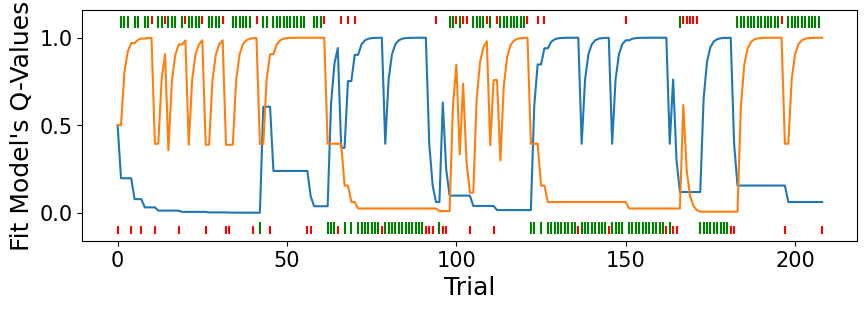

In [43]:
#@title Plot internal workings (latents) of the generating fitted model (aka the Q-values).
# Run the agent on a session

# Run the agent on a session
xs, ys = next(dataset_test)
network_outputs, network_states = rnn_utils.eval_model(bandits.HkAgentQ, rl_params, xs)
network_states = np.array(network_states)
sess_i = 0
trial_end = rnn_utils.find_session_end(xs[:, sess_i, 0])
choices = xs[:trial_end, sess_i, 0]
rewards = xs[:trial_end, sess_i, 1]
rl_activations = network_states[:trial_end, sess_i, :]
bandits.plot_session(
    choices=choices, rewards=rewards, timeseries=rl_activations,
    timeseries_name="Fit Model's Q-Values",
    #timeseriesb=probs_combined[0:n,:],
    )


In [44]:
#@title Fit the RNN (GRU) model
n_steps_max = 5000 #@param
optimizer = optax.adam(learning_rate=1e-2)
n_hidden = 1  #@param
gru_params1, _ = rnn_utils.fit_model(
    model_fun=make_gru,
    dataset=dataset_train,
    optimizer=optimizer,
    convergence_thresh=1e-3,
    n_steps_max=n_steps_max,
    use_gamma=False,
    use_tau=False)
n_hidden = 2  #@param
gru_params2, _ = rnn_utils.fit_model(
    model_fun=make_gru,
    dataset=dataset_train,
    optimizer=optimizer,
    convergence_thresh=1e-3,
    n_steps_max=n_steps_max,
    use_gamma=False,
    use_tau=False)
n_hidden = 4  #@param
gru_params4, _ = rnn_utils.fit_model(
    model_fun=make_gru,
    dataset=dataset_train,
    optimizer=optimizer,
    convergence_thresh=1e-3,
    n_steps_max=n_steps_max,
    use_gamma=False,
    use_tau=False)
n_hidden = 12  #@param
gru_params12, _ = rnn_utils.fit_model(
    model_fun=make_gru,
    dataset=dataset_train,
    optimizer=optimizer,
    convergence_thresh=1e-3,
    n_steps_max=n_steps_max,
    use_gamma=False,
    use_tau=False)

Step 500 of 500; Loss: 1.6110e+04. (Time: 1.4s)
Model not yet converged - Running more steps of gradient descent. Time elapsed = 3e-05s.
Step 500 of 500; Loss: 1.6035e+04. (Time: 1.4s)
Model not yet converged (convergence_value = 0.004654414) - Running more steps of gradient descent. Time elapsed = 2e-05s.
Step 500 of 500; Loss: 1.6017e+04. (Time: 1.4s)
Model not yet converged (convergence_value = 0.001117338) - Running more steps of gradient descent. Time elapsed = 2e-05s.
Step 500 of 500; Loss: 1.6006e+04. (Time: 1.4s)
Model Converged! Time elapsed = 1e-05s.
Step 500 of 500; Loss: 1.6136e+04. (Time: 2.1s)
Model not yet converged - Running more steps of gradient descent. Time elapsed = 1e-05s.
Step 500 of 500; Loss: 1.5997e+04. (Time: 2.1s)
Model not yet converged (convergence_value = 0.00858491) - Running more steps of gradient descent. Time elapsed = 2e-05s.
Step 500 of 500; Loss: 1.5073e+04. (Time: 2.1s)
Model not yet converged (convergence_value = 0.05780063) - Running more steps 

KeyboardInterrupt: 

<Axes: xlabel='Trial', ylabel='Network Activations'>

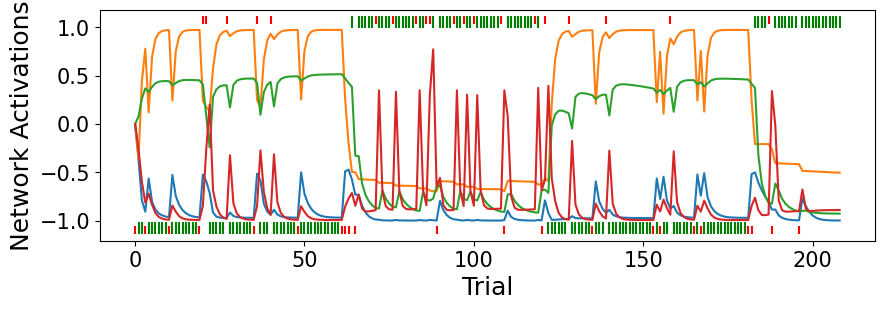

In [ ]:
#@title Plot internal workings of the model
# Run the agent on a session
xs, ys = next(dataset_test)
n_hidden = 4
network_outputs, network_states = rnn_utils.eval_model(make_gru, gru_params4, xs)

# Plot session
network_states = np.array(network_states)
sess_i = 0

trial_end = rnn_utils.find_session_end(xs[:, sess_i, 0])
choices = xs[:trial_end, sess_i, 0]
rewards = xs[:trial_end, sess_i, 1]
gru_activations = network_states[:trial_end, 0, sess_i, :]
#gru_outputs = np.array(jax.nn.softmax(network_outputs[:trial_end, sess_i, :2]))
#gru_outputs = np.argmax(gru_outputs, axis=1)
bandits.plot_session(
    choices=choices,
    rewards=rewards,
    timeseries=gru_activations,
    
    timeseries_name='Network Activations')

In [ ]:
# Report quality of fit to held-out dataset
print('Normalized Likelihoods for Q-Learning Model')
print('Training Dataset')
training_likelihood = compute_log_likelihood(dataset_train, bandits.HkAgentQ, params)
print('Held-Out Dataset')
testing_likelihood = compute_log_likelihood(dataset_test, bandits.HkAgentQ, params)

#@title Compute quality-of-fit: Held-out Normalized Likelihood
# Compute log-likelihood
print('Normalized Likelihoods for GRU')
print('Training Dataset')
n_hidden = 1 
training_likelihood = compute_log_likelihood(dataset_train, make_gru, gru_params1)
print('Held-Out Dataset')
testing_likelihood = compute_log_likelihood(dataset_test, make_gru, gru_params1)

#@title Compute quality-of-fit: Held-out Normalized Likelihood
# Compute log-likelihood
print('Normalized Likelihoods for GRU')
print('Training Dataset')
n_hidden = 4 
training_likelihood = compute_log_likelihood(dataset_train, make_gru, gru_params4)
print('Held-Out Dataset')
testing_likelihood = compute_log_likelihood(dataset_test, make_gru, gru_params4)

Normalized Likelihoods for Q-Learning Model
Training Dataset
Normalized Likelihood: 67.6%
Held-Out Dataset
Normalized Likelihood: 67.7%
Normalized Likelihoods for GRU
Training Dataset
Normalized Likelihood: 69.1%
Held-Out Dataset
Normalized Likelihood: 69.3%
Normalized Likelihoods for GRU
Training Dataset
Normalized Likelihood: 70.4%
Held-Out Dataset
Normalized Likelihood: 70.6%


In [ ]:
#@title Synthesize a dataset using the fitted agent
rl_agent = bandits.AgentNetwork(bandits.HkAgentQ, rl_params)
_, experiment_list_rl = bandits.create_dataset(rl_agent, environment, n_trials_per_session, n_sessions)

TypeError: step() missing 2 required positional arguments: 'isflip' and 'blockindex'

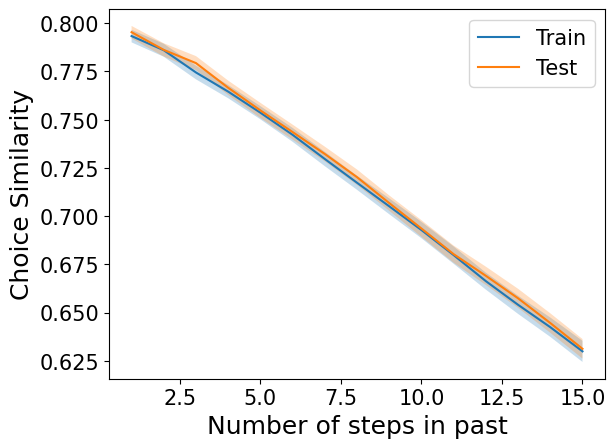

In [ ]:
plotting.plot_action_similarity_to_history(
    experiment_list_train,
    experiment_list_test,
    n_steps_back=16,
    labels=['Train', 'Test', 'RL Model', 'GRU'])

In [ ]:
#@title Set up the RNN (Low-Rank RNN) Model
n_hidden = 4  #@param
rank = 1  #@param

# Define the Low-Rank RNN class
class LowRankRNN(hk.RNNCore):
    def __init__(self, n_hidden, rank):
        super().__init__()
        self.n_hidden = n_hidden
        self.rank = rank

    def __call__(self, inputs, state):
        # Decompose the weight matrix into two smaller matrices
        W1 = hk.Linear(self.rank)(inputs)
        W2 = hk.Linear(self.n_hidden)(W1)
        new_state = jax.nn.tanh(W2 + state)
        return new_state, new_state

    def initial_state(self, batch_size):
        return jnp.zeros([batch_size, self.n_hidden])

def make_low_rank_rnn():
  model = hk.DeepRNN(
      [LowRankRNN(n_hidden, rank), hk.Linear(output_size=2)]
  )
  return model


def initialize_low_rank_rnn_params(gru_params, rank):
    low_rank_rnn_params = {}

    for module_name, module_params in gru_params.items():
        low_rank_rnn_params[module_name] = {}
        for param_name, param_value in module_params.items():
            if param_value.ndim == 2:  # Check if the parameter is a 2-dimensional array
                # Perform SVD on the weight matrix
                U, S, Vt = np.linalg.svd(param_value, full_matrices=False)
                # Keep only the top 'rank' singular values
                U = U[:, :rank]
                S = np.diag(S[:rank])
                Vt = Vt[:rank, :]
                # Initialize the low-rank parameters
                low_rank_rnn_params[module_name][param_name + '_U'] = U
                low_rank_rnn_params[module_name][param_name + '_S'] = S
                low_rank_rnn_params[module_name][param_name + '_Vt'] = Vt
            else:
                # Copy the bias and other parameters directly
                low_rank_rnn_params[module_name][param_name] = param_value

    return low_rank_rnn_params


In [ ]:
# Initialize the low-rank RNN with the trained GRU parameters
rank = 1
low_rank_rnn_params = initialize_low_rank_rnn_params(gru_params4, rank)

# Fine-tune the low-rank RNN
low_rank_rnn_params, _ = rnn_utils.fit_model(
    model_fun=make_low_rank_rnn,
    dataset=dataset_train,
    optimizer=optimizer,
    convergence_thresh=1e-3,
    n_steps_max=n_steps_max,
    use_gamma=False,
    use_tau=False)

Step 500 of 500; Loss: 1.5760e+04. (Time: 1.5s)
Model not yet converged - Running more steps of gradient descent. Time elapsed = 1e-05s.
Step 500 of 500; Loss: 1.5663e+04. (Time: 1.4s)
Model not yet converged (convergence_value = 0.006189683) - Running more steps of gradient descent. Time elapsed = 1e-05s.
Step 500 of 500; Loss: 1.5623e+04. (Time: 1.4s)
Model not yet converged (convergence_value = 0.002525811) - Running more steps of gradient descent. Time elapsed = 2e-05s.
Step 500 of 500; Loss: 1.5610e+04. (Time: 1.4s)
Model Converged! Time elapsed = 1e-05s.


<Axes: xlabel='Trial', ylabel='Network Activations'>

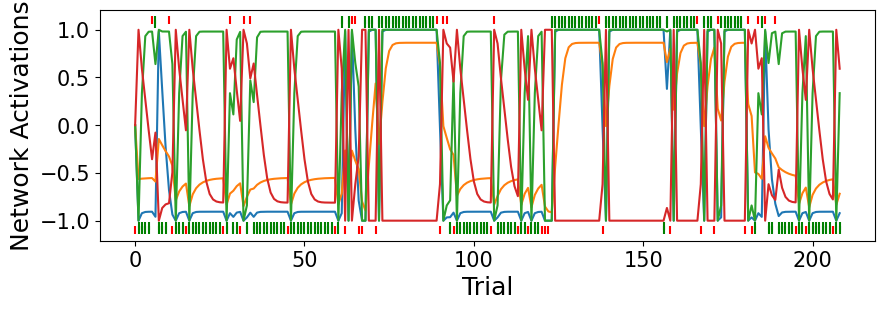

In [ ]:
#@title Plot internal workings of the model
# Run the agent on a session
xs, ys = next(dataset_test)
network_outputs, network_states = rnn_utils.eval_model(make_low_rank_rnn, low_rank_rnn_params, xs)

# Plot session
network_states = np.array(network_states)
sess_i = 0

trial_end = rnn_utils.find_session_end(xs[:, sess_i, 0])
choices = xs[:trial_end, sess_i, 0]
rewards = xs[:trial_end, sess_i, 1]
gru_activations = network_states[:trial_end, 0, sess_i, :]
bandits.plot_session(
    choices=choices,
    rewards=rewards,
    timeseries=gru_activations,
    timeseries_name='Network Activations')

In [ ]:
# Report quality of fit to held-out dataset
print('Normalized Likelihoods for Q-Learning Model')
print('Training Dataset')
training_likelihood = compute_log_likelihood(dataset_train, bandits.HkAgentQ, params)
print('Held-Out Dataset')
testing_likelihood = compute_log_likelihood(dataset_test, bandits.HkAgentQ, params)

#@title Compute quality-of-fit: Held-out Normalized Likelihood
# Compute log-likelihood
print('Normalized Likelihoods for GRU with 1 hidden unit')
print('Training Dataset')
n_hidden = 1 
training_likelihood = compute_log_likelihood(dataset_train, make_gru, gru_params1)
print('Held-Out Dataset')
testing_likelihood = compute_log_likelihood(dataset_test, make_gru, gru_params1)

#@title Compute quality-of-fit: Held-out Normalized Likelihood
# Compute log-likelihood
print('Normalized Likelihoods for GRU with 2 hidden unit')
print('Training Dataset')
n_hidden = 2 
training_likelihood = compute_log_likelihood(dataset_train, make_gru, gru_params2)
print('Held-Out Dataset')
testing_likelihood = compute_log_likelihood(dataset_test, make_gru, gru_params2)

#@title Compute quality-of-fit: Held-out Normalized Likelihood
# Compute log-likelihood
print('Normalized Likelihoods for GRU with 4 hidden units')
print('Training Dataset')
n_hidden = 4 
training_likelihood = compute_log_likelihood(dataset_train, make_gru, gru_params4)
print('Held-Out Dataset')
testing_likelihood = compute_log_likelihood(dataset_test, make_gru, gru_params4)

#@title Compute quality-of-fit: Held-out Normalized Likelihood
# Compute log-likelihood
print('Normalized Likelihoods for lRNK with 4 hidden units and rank 1')
print('Training Dataset')
n_hidden = 4 
training_likelihood = compute_log_likelihood(dataset_train, make_low_rank_rnn, low_rank_rnn_params)
print('Held-Out Dataset')
testing_likelihood = compute_log_likelihood(dataset_test, make_low_rank_rnn, low_rank_rnn_params)

#@title Compute quality-of-fit: Held-out Normalized Likelihood
# Compute log-likelihood
print('Normalized Likelihoods for GRU with 12 hidden units')
print('Training Dataset')
n_hidden = 12 
training_likelihood = compute_log_likelihood(dataset_train, make_gru, gru_params12)
print('Held-Out Dataset')
testing_likelihood = compute_log_likelihood(dataset_test, make_gru, gru_params12)

Normalized Likelihoods for Q-Learning Model
Training Dataset
Normalized Likelihood: 67.3%
Held-Out Dataset
Normalized Likelihood: 67.3%
Normalized Likelihoods for GRU with 1 hidden unit
Training Dataset
Normalized Likelihood: 71.0%
Held-Out Dataset
Normalized Likelihood: 70.8%
Normalized Likelihoods for GRU with 2 hidden unit
Training Dataset
Normalized Likelihood: 72.2%
Held-Out Dataset
Normalized Likelihood: 71.9%
Normalized Likelihoods for GRU with 4 hidden units
Training Dataset
Normalized Likelihood: 72.8%
Held-Out Dataset
Normalized Likelihood: 72.5%
Normalized Likelihoods for lRNK with 4 hidden units and rank 1
Training Dataset
Normalized Likelihood: 71.2%
Held-Out Dataset
Normalized Likelihood: 71.1%
Normalized Likelihoods for GRU with 12 hidden units
Training Dataset
Normalized Likelihood: 73.7%
Held-Out Dataset
Normalized Likelihood: 69.2%


In [ ]:
#@title Synthesize a dataset using the fit network
gru_agent = bandits.AgentNetwork(make_gru, gru_params)
_, experiment_list_gru = bandits.create_flip_dataset(gru_agent, environment, n_trials_per_session, n_sessions)

In [46]:
#@title Set up Disentangled RNN.
#@markdown Number of latent units in the model.
latent_size = 4  #@param

#@markdown Number of hidden units in each of the two layers of the update MLP.
update_mlp_shape = (3,3,)  #@param

#@markdown Number of hidden units in each of the two layers of the choice MLP.
choice_mlp_shape = (2,)

def make_disrnn():
  model = disrnn.HkDisRNN(latent_size = latent_size,
                          update_mlp_shape = update_mlp_shape,
                          choice_mlp_shape = choice_mlp_shape,
                          target_size=2)
  return model

def make_disrnn_eval():
  model = disrnn.HkDisRNN(latent_size = latent_size,
                          update_mlp_shape = update_mlp_shape,
                          choice_mlp_shape = choice_mlp_shape,
                          target_size=2,
                          eval_mode=True)
  return model


optimizer = optax.adam(learning_rate=1e-2)

In [ ]:
#@title Fit disRNN with no penalty at first, to get good quality-of-fit
#@markdown You can experiment with different values, but colab has been tested with 1000.

n_steps = 1000 #@param
information_penalty = 0

disrnn_params, opt_state, losses = rnn_utils.train_model(
    model_fun = make_disrnn,
    dataset = dataset_train,
    optimizer = optimizer,
    loss_fun = 'penalized_categorical',
    penalty_scale=information_penalty,
    n_steps=n_steps,
    do_plot=False,
    truncate_seq_length=200,
)

Step 1000 of 1000; Loss: 1.4106e+04. (Time: 17.8s)

Step 3000 of 3000; Loss: 1.4516e+04. (Time: 51.3s)

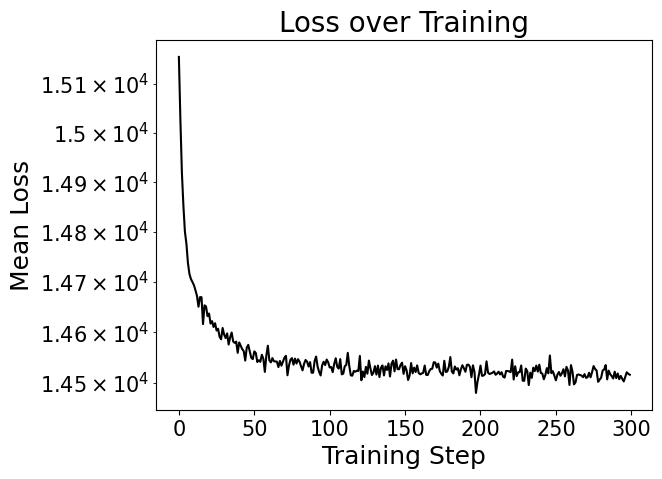

In [ ]:
#@title Now fit more steps with a penalty, to encourage it to find a simple solution
#@markdown You can experiment with different values, but colab has been tested with 3000.
n_steps = 3000  #@param
information_penalty = 1e-3  #@param

disrnn_params, opt_state, losses = rnn_utils.train_model(
    model_fun = make_disrnn,
    dataset = dataset_train,
    optimizer = optimizer,
    loss_fun = 'penalized_categorical',
    params=disrnn_params,
    opt_state=opt_state,
    penalty_scale=information_penalty,
    n_steps=n_steps,
    truncate_seq_length=200,
)

<Axes: xlabel='Trial', ylabel='Network Activations'>

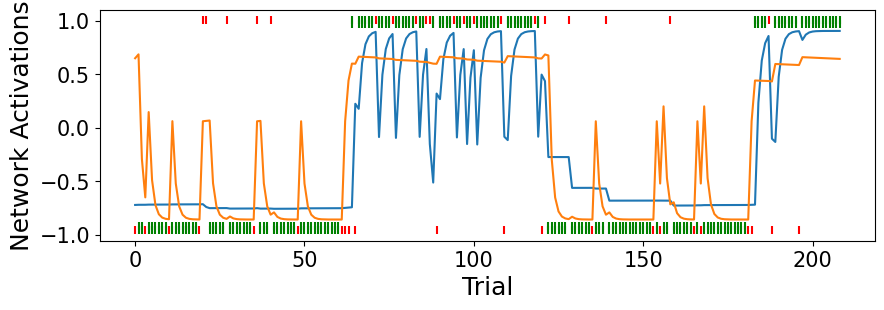

In [ ]:
#@title Plot example session: latents + choices.
importlib.reload(bandits)
xs, ys = next(dataset_test)
sess_i = 0
trial_end = rnn_utils.find_session_end(xs[:, sess_i, 0])
network_outputs, network_states = rnn_utils.eval_model(
    make_disrnn_eval, disrnn_params, xs[:trial_end, sess_i:sess_i+1])
network_states = np.array(network_states)
choices = xs[:trial_end, sess_i, 0]
rewards = xs[:trial_end, sess_i, 1]
disrnn_activations = network_states[:trial_end, sess_i, :]
bandits.plot_session(choices=choices,
                     rewards=rewards,
                     timeseries=disrnn_activations,
                     timeseries_name='Network Activations')

In [ ]:
#@title Compute quality-of-fit: Held-out Normalized Likelihood
# Compute log-likelihood
print('Normalized Likelihoods for disentangled RNN with 2 hidden units')
print('Training Dataset')
training_likelihood = compute_log_likelihood(dataset_train, make_disrnn_eval, disrnn_params)
print('Held-Out Dataset')
testing_likelihood = compute_log_likelihood(dataset_test, make_disrnn_eval, disrnn_params)

Normalized Likelihoods for disentangled RNN with 2 hidden units
Training Dataset
Normalized Likelihood: 72.7%
Held-Out Dataset
Normalized Likelihood: 72.5%


In [ ]:
#@title Set up Hybrid RNN.

#@markdown Is the model recurrent (ie can it see the hidden state from the previous step)
use_hidden_state = 'True'  #@param ['True', 'False']

#@markdown Is the model recurrent (ie can it see the hidden state from the previous step)
use_previous_values = 'False'  #@param

#@markdown If True, learn a value for the forgetting term
fit_forget = "True"  #@param

#@markdown Learn a reward-independent term that depends on past choices.
habit_weight = 1  #@param [0, 1]

value_weight = 1.  # This is needed for it to be doing RL

rnn_rl_params = {
    's': use_hidden_state == 'True',
    'o': use_previous_values == 'True',
    'fit_forget': fit_forget == 'True',
    'forget': 0.,
    'w_h': habit_weight,
    'w_v': value_weight}
network_params = {'n_actions': 2, 'hidden_size': 4}

def make_hybrnn():
  model = hybrnn.BiRNN(rl_params=rnn_rl_params, network_params=network_params)
  return model

optimizer = optax.adam(learning_rate=1e-2)

In [ ]:
#@title Fit the hybrid RNN
hybrnn_params, _ = rnn_utils.fit_model(
    model_fun=make_hybrnn,
    dataset=dataset_train,
    optimizer=optimizer,
    loss_fun='categorical',
    convergence_thresh=1e-4,
    n_steps_max=5000,
)


Step 500 of 500; Loss: 1.4784e+04. (Time: 2.6s)
Model not yet converged - Running more steps of gradient descent. Time elapsed = 1e-05s.
Step 500 of 500; Loss: 1.4876e+04. (Time: 2.7s)
Model not yet converged (convergence_value = 0.006225592) - Running more steps of gradient descent. Time elapsed = 1e-05s.
Step 500 of 500; Loss: 1.4765e+04. (Time: 2.6s)
Model not yet converged (convergence_value = 0.007453229) - Running more steps of gradient descent. Time elapsed = 2e-05s.
Step 500 of 500; Loss: 1.4815e+04. (Time: 2.6s)
Model not yet converged (convergence_value = 0.003406399) - Running more steps of gradient descent. Time elapsed = 2e-05s.
Step 500 of 500; Loss: 1.4830e+04. (Time: 2.5s)
Model not yet converged (convergence_value = 0.001031858) - Running more steps of gradient descent. Time elapsed = 2e-05s.
Step 500 of 500; Loss: 1.4793e+04. (Time: 2.5s)
Model not yet converged (convergence_value = 0.002516866) - Running more steps of gradient descent. Time elapsed = 2e-05s.
Step 500

<Axes: xlabel='Trial', ylabel='Hybrid RNN Values'>

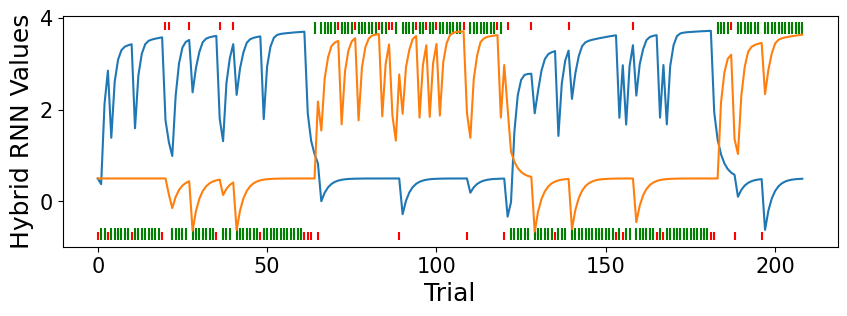

In [ ]:
#@title Plot example session: latents + choices.
importlib.reload(bandits)
xs, ys = next(dataset_test)
sess_i = 0
trial_end = rnn_utils.find_session_end(xs[:, sess_i, 0])
network_outputs, network_states = rnn_utils.eval_model(
    make_hybrnn, hybrnn_params, xs)
#@title Save out latent variables from the network.
xs, ys = next(dataset_test)
network_outputs, network_states = rnn_utils.eval_model(make_hybrnn, hybrnn_params, xs)

h_state = np.zeros((n_trials_per_session, n_sessions, network_params['hidden_size']))
v_state = np.zeros((n_trials_per_session, n_sessions, network_params['hidden_size']))
h = np.zeros((n_trials_per_session, n_sessions, network_params['n_actions']))
v = np.zeros((n_trials_per_session, n_sessions, network_params['n_actions']))

for t in range(n_trials_per_session):
  for s in range(len(network_states)):
    h_state[t] = network_states[t][0]
    v_state[t] = network_states[t][1]
    h[t] = network_states[t][2]
    v[t] = network_states[t][3]

    sess_i = 0
choices = xs[:, sess_i, 0]
rewards = xs[:, sess_i, 1]

hybrnn_values = v[:, sess_i, :]
hybrnn_v_state = v_state[:, sess_i, :]


bandits.plot_session(choices=choices,
                     rewards=rewards,
                     timeseries=hybrnn_values,
                     timeseries_name='Hybrid RNN Values')


In [ ]:
#@title Compute quality-of-fit: Held-out Normalized Likelihood
# Compute log-likelihood
print('Normalized Likelihoods for hybrid RNN with 4 hidden units')
print('Training Dataset')
training_likelihood = compute_log_likelihood(dataset_train, make_hybrnn, hybrnn_params)
print('Held-Out Dataset')
testing_likelihood = compute_log_likelihood(dataset_test, make_hybrnn, hybrnn_params)

Normalized Likelihoods for hybrid RNN with 2 hidden units
Training Dataset
Normalized Likelihood: 72.6%
Held-Out Dataset
Normalized Likelihood: 72.3%


In [245]:
importlib.reload(rat_data)
LOCAL_PATH_TO_FILE = "/Users/kiralyb/Downloads/behavfiles/BAD15.mat"  #@param
if not os.path.exists(LOCAL_PATH_TO_FILE):
    raise ValueError('File not found.')
FNAME_ = LOCAL_PATH_TO_FILE

dataset_train, dataset_test = rat_data.format_into_datasets(
    *rat_data.load_data_for_one_rat(FNAME_, '.')[:2], rnn_utils.DatasetRNN)
n_trials_per_session, n_sessions, _ = dataset_train._xs.shape
experiment_list_train = None
experiment_list_test = None

begin_session = 20
# Extract data for the current session
xs_session = dataset_train._xs[:, begin_session:, :]
ys_session = dataset_train._ys[:, begin_session:, :]
#xs_session = xs_session.reshape(xs_session.shape[0], 1, xs_session.shape[1])
#ys_session = ys_session.reshape(ys_session.shape[0], 1, ys_session.shape[1])
# Create a dataset for the current session
dataset_session = rnn_utils.DatasetRNN(xs_session, ys_session)
dataset_train = dataset_session

In [1]:
session = -5 #@param
Mdata = loadmat(os.path.join('.',FNAME_))
probs = Mdata['PROBS']
probs_combined = np.vstack((1 - probs[:, session],probs[:, session], )).T

n = np.where(dataset_train._xs[:, session, 0] == -1)[0][0]
window_size = 10 #@param
choices_moving_avg = np.convolve(dataset_train._xs[0:n, session, 0], np.ones(window_size) / window_size, mode='same')
print(dataset_train._xs[0:n, session, 0].dtype)
ax = bandits.plot_session(
    choices=dataset_train._xs[0:n, session, 0],
    rewards=dataset_train._xs[0:n, session, 1],
    timeseries=choices_moving_avg, #0:n, session, 0],
    timeseriesb=probs_combined[0:n,:],
    timeseries_name='Choice ratio',
)


NameError: name 'loadmat' is not defined

In [246]:
#@title Fit parameters
# Train only on the last session

rl_params, _ = rnn_utils.fit_model(
    model_fun=bandits.HkAgentQ,
    dataset=dataset_train,
    loss_fun='categorical',
    optimizer=optax.adam(1e-1),
    convergence_thresh=1e-5,
    n_steps_per_call=500,
    n_steps_max=5000,
    use_tau=True)

Step 500 of 500; Loss: 1.4778e+03. (Time: 0.5s)
Model not yet converged - Running more steps of gradient descent. Time elapsed = 1e-05s.
Step 500 of 500; Loss: 1.4778e+03. (Time: 0.5s)
Model Converged! Time elapsed = 1e-05s.


In [247]:
fit_alpha = jax.nn.sigmoid(rl_params['hk_agent_q']['alpha_unsigmoid'][0])
fit_beta = rl_params['hk_agent_q']['beta'][0]
fit_tau = rl_params['hk_agent_q']['tau'][0]

print('Recovered beta was: ', fit_beta)
print('Recovered tau was: ', fit_tau)
print('Recovered alpha was: ', fit_alpha)

Recovered beta was:  2.5199049
Recovered tau was:  1.4115529
Recovered alpha was:  0.6472141


<Axes: xlabel='Trial', ylabel="Fit Model's Q-Values">

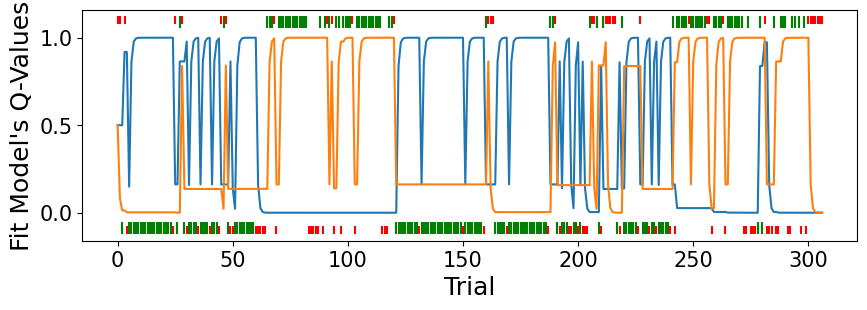

In [205]:
#@title Plot internal workings (latents) of the generating fitted model (aka the Q-values).
# Run the agent on a session

# Run the agent on a session
xs, ys = next(dataset_test)
network_outputs, network_states = rnn_utils.eval_model(bandits.HkAgentQ, rl_params, xs)
network_states = np.array(network_states)
sess_i = 10
trial_end = rnn_utils.find_session_end(xs[:, sess_i, 0])
choices = xs[:trial_end, sess_i, 0]
rewards = xs[:trial_end, sess_i, 1]
rl_activations = network_states[:trial_end, sess_i, :]
bandits.plot_session(
    choices=choices, rewards=rewards, timeseries=rl_activations,
    timeseries_name="Fit Model's Q-Values",
    #timeseriesb=probs_combined[0:n,:],
    )


In [ ]:
#@title Fit the RNN (GRU) model
n_steps_max = 5000 #@param
optimizer = optax.adam(learning_rate=1e-2)
n_hidden = 4  #@param

gru_params4, _ = rnn_utils.fit_model(
    model_fun=make_gru,
    dataset=dataset_train,
    optimizer=optimizer,
    convergence_thresh=1e-3,
    n_steps_max=n_steps_max,
    use_gamma=False,
    use_tau=False)

<Axes: xlabel='Trial', ylabel='Network Activations'>

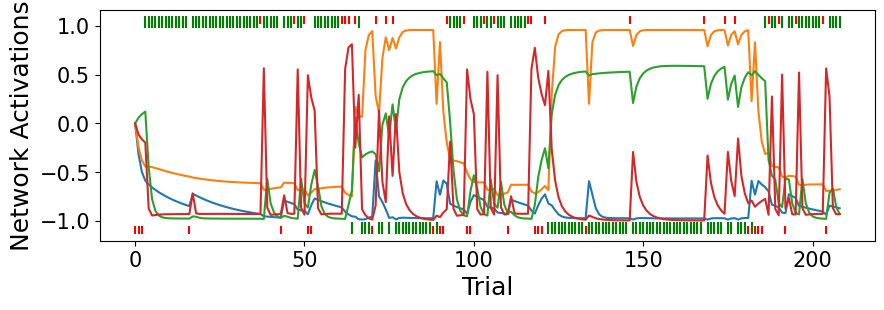

In [52]:
#@title Plot internal workings of the model
# Run the agent on a session
xs, ys = next(dataset_test)
n_hidden = 4
network_outputs, network_states = rnn_utils.eval_model(make_gru, gru_params4, xs)

# Plot session
network_states = np.array(network_states)
sess_i = 10

trial_end = rnn_utils.find_session_end(xs[:, sess_i, 0])
choices = xs[:trial_end, sess_i, 0]
rewards = xs[:trial_end, sess_i, 1]
gru_activations = network_states[:trial_end, 0, sess_i, :]
#gru_outputs = np.array(jax.nn.softmax(network_outputs[:trial_end, sess_i, :2]))
#gru_outputs = np.argmax(gru_outputs, axis=1)
bandits.plot_session(
    choices=choices,
    rewards=rewards,
    timeseries=gru_activations,
    
    timeseries_name='Network Activations')

In [248]:
#@title Fit disRNN with no penalty at first, to get good quality-of-fit
#@markdown You can experiment with different values, but colab has been tested with 1000.

n_steps = 1000 #@param
information_penalty = 0

disrnn_params, opt_state, losses = rnn_utils.train_model(
    model_fun = make_disrnn,
    dataset = dataset_train,
    optimizer = optimizer,
    loss_fun = 'penalized_categorical',
    penalty_scale=information_penalty,
    n_steps=n_steps,
    do_plot=False,
    truncate_seq_length=200,
)

Step 1000 of 1000; Loss: 9.0400e+02. (Time: 6.1s)

Step 3000 of 3000; Loss: 1.0260e+03. (Time: 15.9s)

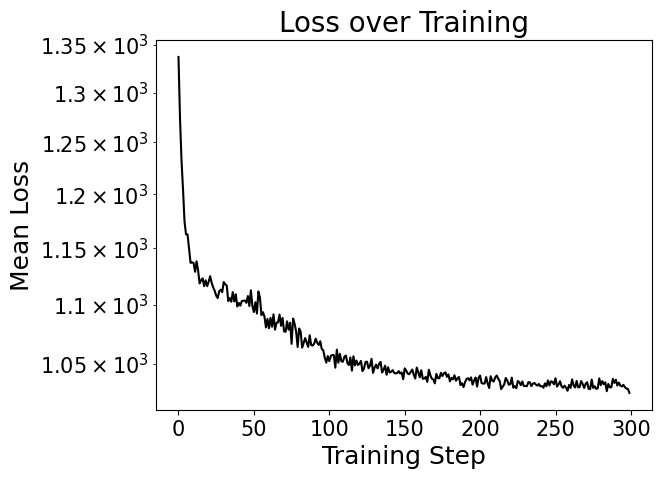

In [ ]:
#@title Now fit more steps with a penalty, to encourage it to find a simple solution
#@markdown You can experiment with different values, but colab has been tested with 3000.
n_steps = 3000  #@param
information_penalty = 1e-3  #@param

disrnn_params, opt_state, losses = rnn_utils.train_model(
    model_fun = make_disrnn,
    dataset = dataset_train,
    optimizer = optimizer,
    loss_fun = 'penalized_categorical',
    params=disrnn_params,
    opt_state=opt_state,
    penalty_scale=information_penalty,
    n_steps=n_steps,
    truncate_seq_length=200,
)

<Axes: xlabel='Trial', ylabel='Network Activations'>

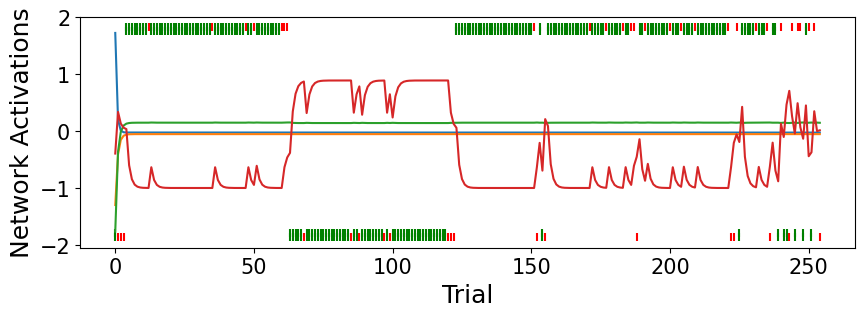

In [250]:
#@title Plot example session: latents + choices.

xs, ys = next(dataset_test)
network_outputs, network_states = rnn_utils.eval_model(make_disrnn_eval, disrnn_params, xs)


# Plot session
network_states = np.array(network_states)
sess_i = 10

trial_end = rnn_utils.find_session_end(xs[:, sess_i, 0])
choices = xs[:trial_end, sess_i, 0]
rewards = xs[:trial_end, sess_i, 1]
gru_activations = network_states[:trial_end, sess_i, :]
#gru_outputs = np.array(jax.nn.softmax(network_outputs[:trial_end, sess_i, :2]))
#gru_outputs = np.argmax(gru_outputs, axis=1)
bandits.plot_session(
    choices=choices,
    rewards=rewards,
    timeseries=gru_activations,
    timeseries_name='Network Activations')

In [220]:
# Report quality of fit to held-out dataset
print('Normalized Likelihoods for Q-Learning Model')
print('Training Dataset')
training_likelihood = compute_log_likelihood(dataset_train, bandits.HkAgentQ, rl_params)
print('Held-Out Dataset')
testing_likelihood = compute_log_likelihood(dataset_test, bandits.HkAgentQ, rl_params)

#@title Compute quality-of-fit: Held-out Normalized Likelihood
# Compute log-likelihood
print('Normalized Likelihoods for GRU')
print('Training Dataset')
n_hidden = 4 
training_likelihood = compute_log_likelihood(dataset_train, make_gru, gru_params4)
print('Held-Out Dataset')
testing_likelihood = compute_log_likelihood(dataset_test, make_gru, gru_params4)

#@title Compute quality-of-fit: Held-out Normalized Likelihood
# Compute log-likelihood
print('Normalized Likelihoods for Disentangled RNN')
print('Training Dataset')
n_hidden = 4 
training_likelihood = compute_log_likelihood(dataset_train, make_disrnn_eval, disrnn_params)
print('Held-Out Dataset')
testing_likelihood = compute_log_likelihood(dataset_test, make_disrnn_eval, disrnn_params)


Normalized Likelihoods for Q-Learning Model
Training Dataset
Normalized Likelihood: 71.3%
Held-Out Dataset
Normalized Likelihood: 65.0%
Normalized Likelihoods for GRU
Training Dataset
Normalized Likelihood: 59.4%
Held-Out Dataset
Normalized Likelihood: 57.9%
Normalized Likelihoods for Disentangled RNN
Training Dataset
Normalized Likelihood: 60.1%
Held-Out Dataset
Normalized Likelihood: 12.8%


In [258]:
#@title Set up environment
env_contingencies = [0.9,0.7] # probability of reward in the likely reward side
env_flip_freq = [30,60,90] # contingency flip frequencies
n_actions = 2
#environment = bandits.EnvironmentBanditsFlipsFreq(block_flip_freq=env_flip_freq, reward_probs=env_contingencies) #, predif_sequence = [2,1,0,1,0,0,0,1,1])
environment = bandits.EnvironmentBanditsFlipsFreq(block_flip_freq=env_flip_freq, reward_probs=env_contingencies)
#@title Synthesize a dataset using the fit network
rnn_agent = bandits.AgentNetwork(make_disrnn_eval, disrnn_params)

dataset_rnn, experiment_list_test = bandits.create_flip_dataset(
      agent=rnn_agent,
      environment=environment,
      n_trials_per_session=200,
      n_sessions=10)

In [259]:
#@title Fit parameters
rl_params, _ = rnn_utils.fit_model(
    model_fun=bandits.HkAgentQ,
    dataset=dataset_rnn,
    loss_fun='categorical',
    optimizer=optax.adam(1e-1),
    convergence_thresh=1e-5,
    n_steps_per_call=500,
    n_steps_max=5000,
    use_tau=True)

Step 500 of 500; Loss: 5.0092e+02. (Time: 0.2s)
Model not yet converged - Running more steps of gradient descent. Time elapsed = 1e-05s.
Step 500 of 500; Loss: 5.0092e+02. (Time: 0.2s)
Model Converged! Time elapsed = 1e-05s.


In [260]:
fit_alpha = jax.nn.sigmoid(rl_params['hk_agent_q']['alpha_unsigmoid'][0])
fit_beta = rl_params['hk_agent_q']['beta'][0]/2
fit_tau = rl_params['hk_agent_q']['tau'][0]

print('Recovered beta was: ', fit_beta)
print('Recovered alpha was: ', fit_alpha)
print('Recovered tau was: ', fit_tau)

Recovered beta was:  1.253539
Recovered alpha was:  0.8561964
Recovered tau was:  1.3140208


<Axes: xlabel='Trial', ylabel="Fit Model's Q-Values">

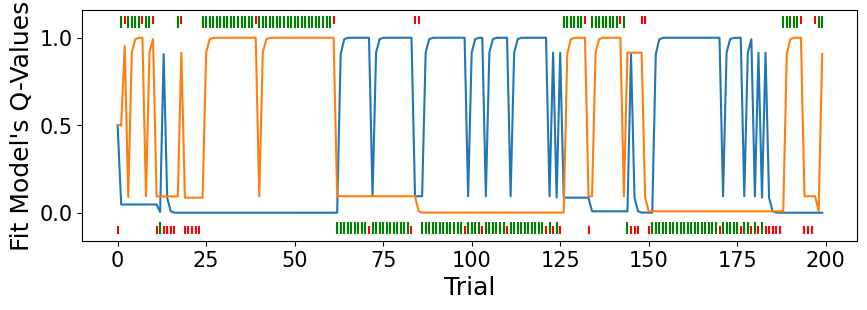

In [254]:
#@title Plot internal workings (latents) of the generating fitted model (aka the Q-values).
# Run the agent on a session

# Run the agent on a session
xs, ys = next(dataset_rnn)
network_outputs, network_states = rnn_utils.eval_model(bandits.HkAgentQ, rl_params, xs)
network_states = np.array(network_states)
sess_i = 1
trial_end = rnn_utils.find_session_end(xs[:, sess_i, 0])
choices = xs[:trial_end, sess_i, 0]
rewards = xs[:trial_end, sess_i, 1]
rl_activations = network_states[:trial_end, sess_i, :]
bandits.plot_session(
    choices=choices, rewards=rewards, timeseries=rl_activations,
    timeseries_name="Fit Model's Q-Values",
    #timeseriesb=probs_combined[0:n,:],
    )


<Axes: xlabel='Trial', ylabel="Fit Model's Q-Values">

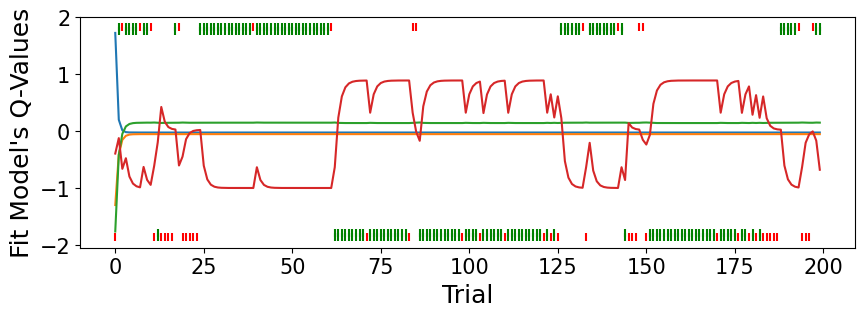

In [255]:
#@title Plot internal workings (latents) of the generating fitted model (aka the Q-values).
# Run the agent on a session

# Run the agent on a session
xs, ys = next(dataset_rnn)
network_outputs, network_states = rnn_utils.eval_model(make_disrnn_eval, disrnn_params, xs)
network_states = np.array(network_states)
sess_i = 1
trial_end = rnn_utils.find_session_end(xs[:, sess_i, 0])
choices = xs[:trial_end, sess_i, 0]
rewards = xs[:trial_end, sess_i, 1]
rl_activations = network_states[:trial_end, sess_i, :]
bandits.plot_session(
    choices=choices, rewards=rewards, timeseries=rl_activations,
    timeseries_name="Fit Model's Q-Values",
    #timeseriesb=probs_combined[0:n,:],
    )

In [101]:
#@title Set up environment
env_contingencies = [0.9,0.9] # probability of reward in the likely reward side
env_flip_freq = [30,60,90] # contingency flip frequencies
n_actions = 2
#environment = bandits.EnvironmentBanditsFlipsFreq(block_flip_freq=env_flip_freq, reward_probs=env_contingencies) #, predif_sequence = [2,1,0,1,0,0,0,1,1])
environment = bandits.EnvironmentBanditsFlipsFreq(block_flip_freq=env_flip_freq, reward_probs=env_contingencies)

#@title Set up Disentangled RNN.
#@markdown Number of latent units in the model.
latent_size = 5  #@param

#@markdown Number of hidden units in each of the two layers of the update MLP.
update_mlp_shape = (3,3,)  #@param

#@markdown Number of hidden units in each of the two layers of the choice MLP.
choice_mlp_shape = (2,)

def make_disrnn():
  model = disrnn.HkDisRNN(latent_size = latent_size,
                          update_mlp_shape = update_mlp_shape,
                          choice_mlp_shape = choice_mlp_shape,
                          target_size=2)
  return model

def make_disrnn_eval():
  model = disrnn.HkDisRNN(latent_size = latent_size,
                          update_mlp_shape = update_mlp_shape,
                          choice_mlp_shape = choice_mlp_shape,
                          target_size=2,
                          eval_mode=True)
  return model




optimizer = optax.adam(learning_rate=1e-2)

In [ ]:
model_fun = make_disrnn
eval_fun = make_disrnn_eval

importlib.reload(rat_data)
folder_path = "/Users/kiralyb/Downloads/behavfiles/"
# List all files in the folder, excluding hidden files like .DS_Store
files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f)) and not f.startswith('.')]
# Remove 'BSS38.mat' from files if it exists
if 'BDA48.mat' in files:
    files.remove('BDA48.mat')
if 'BDA49.mat' in files:
    files.remove('BDA49.mat')
if 'BDA50.mat' in files:
    files.remove('BDA50.mat')
if 'BSS56.mat' in files:
    files.remove('BSS56.mat')
if 'BAD46.mat' in files:
    files.remove('BAD46.mat')
if 'BAD47.mat' in files:
    files.remove('BAD47.mat') 
if 'BAD45.mat' in files:
    files.remove('BAD45.mat')     
if 'BAD12.mat' in files:
    files.remove('BAD12.mat')
if 'BAS22.mat' in files:
    files.remove('BAS22.mat')  # not enough data
if 'BSS31.mat' in files:
    files.remove('BSS31.mat')  # nagyon biased     

          


all_params = {}  # Initialize the dictionary to store parameters for all files

for file in files:
    # Initialize the dictionary for the current file
    
    LOCAL_PATH_TO_FILE = os.path.join(folder_path, file)
    LOCAL_PATH_TO_VALUEFILE = os.path.join(folder_path, 'VALUES', file.replace('.mat', '_values.mat'))
    
    dataset_train, dataset_test = rat_data.format_into_datasets(
        *rat_data.load_data_for_one_rat(LOCAL_PATH_TO_FILE, '.')[:2], rnn_utils.DatasetRNN)
    n_trials_per_session, n_sessions, _ = dataset_train._xs.shape
    experiment_list_train = None
    experiment_list_test = None
    VALUES = loadmat(LOCAL_PATH_TO_VALUEFILE)
    environments = VALUES['ENVIRONMENT']
    
    # Find indices where environments is 'env_baseline' (strip spaces for matching)
    sessions = np.where((np.char.strip(environments) == 'env_baseline') | (np.char.strip(environments) == 'env_volatility_controled'))[0]
    #sessions = np.where((np.char.strip(environments) != 'env_pretraining'))[0]
    sessions = np.random.permutation(sessions)
    # Extract data for the current environment
    split = int(len(sessions) * 0.8)

    xs_train = dataset_train._xs[:, sessions[:split], :]
    ys_train = dataset_train._ys[:, sessions[:split], :] 
    xs_test = dataset_train._xs[:, sessions[split:], :]
    ys_test = dataset_train._ys[:, sessions[split:], :]
    dataset_train = rnn_utils.DatasetRNN(xs_train, ys_train)
    dataset_test = rnn_utils.DatasetRNN(xs_test, ys_test)

    
    n_steps = 200 #@param
    information_penalty = 0
    
    disrnn_params, opt_state, losses = rnn_utils.train_model(
        model_fun = model_fun,
        dataset = dataset_train,
        optimizer = optimizer,
        loss_fun = 'penalized_categorical',
        penalty_scale=information_penalty,
        n_steps=n_steps,
        do_plot=False,
        truncate_seq_length=200,
    )
    n_steps = 500  #@param
    information_penalty = 1e-3  #@param

    disrnn_params, opt_state, losses = rnn_utils.train_model(
        model_fun = make_disrnn,
        dataset = dataset_train,
        optimizer = optimizer,
        loss_fun = 'penalized_categorical',
        params=disrnn_params,
        opt_state=opt_state,
        penalty_scale=information_penalty,
        n_steps=n_steps,
        do_plot=False,
        truncate_seq_length=200,
    )

  
    rl_params, _ = rnn_utils.fit_model(
            model_fun=bandits.HkAgentQ,
            dataset=dataset_train,
            loss_fun='categorical',
            optimizer=optax.adam(1e-1),
            convergence_thresh=1e-5,
            n_steps_per_call=100,
            n_steps_max=1000,
            use_tau=True,
            parameter_bounds={'beta': (0.0, 5.0),'tau': (-2.0, 2.0)}#, 'alpha_unsigmoid': (jax.scipy.special.logit(0.05), jax.scipy.special.logit(1)), 'gamma_unsigmoid': (jax.scipy.special.logit(0), jax.scipy.special.logit(0.1))},  # Constrained bounds        )
        )

    fit_alpha = jax.nn.sigmoid(rl_params['hk_agent_q']['alpha_unsigmoid'][0])
    fit_beta = rl_params['hk_agent_q']['beta'][0]
    fit_tau = rl_params['hk_agent_q']['tau'][0]

    #@title Compute quality-of-fit: Held-out Normalized Likelihood
    # Compute log-likelihood
    print('Normalized Likelihoods for Q-Learning Model')
    print('Training Dataset')
    training_likelihood_RL = compute_log_likelihood(dataset_train, bandits.HkAgentQ, rl_params)
    print('Held-Out Dataset')
    testing_likelihood_RL = compute_log_likelihood(dataset_test, bandits.HkAgentQ, rl_params)
    print('Normalized Likelihoods for Disentangled RNN')
    print('Training Dataset')
    training_likelihood_RNN = compute_log_likelihood(dataset_train, eval_fun, disrnn_params)
    print('Held-Out Dataset')
    testing_likelihood_RNN = compute_log_likelihood(dataset_test, eval_fun, disrnn_params)

    #@title Synthesize a dataset using the fit network
    rnn_agent = bandits.AgentNetwork(make_disrnn_eval, disrnn_params)

    dataset_rnn, experiment_list_test = bandits.create_flip_dataset(
      agent=rnn_agent,
      environment=environment,
      n_trials_per_session=250,
      n_sessions=10)
    
    rl_params, _ = rnn_utils.fit_model(
        model_fun=bandits.HkAgentQ,
        dataset=dataset_rnn,
        loss_fun='categorical',
        optimizer=optax.adam(1e-1),
        convergence_thresh=1e-5,
        n_steps_per_call=100,
        n_steps_max=1000,
        use_tau=True,
        parameter_bounds={'beta': (0.0, 5.0),'tau': (-2.0, 2.0)}#, 'alpha_unsigmoid': (jax.scipy.special.logit(0.05), jax.scipy.special.logit(1)), 'gamma_unsigmoid': (jax.scipy.special.logit(0), jax.scipy.special.logit(0.1))},  # Constrained bounds        )
    )

    refit_alpha = jax.nn.sigmoid(rl_params['hk_agent_q']['alpha_unsigmoid'][0])
    refit_beta = rl_params['hk_agent_q']['beta'][0]
    refit_tau = rl_params['hk_agent_q']['tau'][0]

    all_params[file] = {
        'fit_alpha': fit_alpha,
        'fit_beta': fit_beta,
        'fit_tau': fit_tau,
        'refit_alpha': refit_alpha,
        'refit_beta': refit_beta,
        'refit_tau': refit_tau,
        'training_likelihood_RL': training_likelihood_RL,
        'testing_likelihood_RL': testing_likelihood_RL,
        'training_likelihood_RNN': training_likelihood_RNN,
        'testing_likelihood_RNN': testing_likelihood_RNN
    }

Step 100 of 100; Loss: 2.5572e+02. (Time: 0.2s)
Model not yet converged - Running more steps of gradient descent. Time elapsed = 2e-05s.
Step 100 of 100; Loss: 2.5572e+02. (Time: 0.1s)
Model Converged! Time elapsed = 2e-05s.
Normalized Likelihoods for Q-Learning Model
Training Dataset
Normalized Likelihood: 81.3%
Held-Out Dataset
Normalized Likelihood: 71.7%
Normalized Likelihoods for Disentangled RNN
Training Dataset
Normalized Likelihood: 81.1%
Held-Out Dataset
Normalized Likelihood: 62.2%
Step 100 of 100; Loss: 7.1155e+02. (Time: 0.2s)
Model not yet converged - Running more steps of gradient descent. Time elapsed = 1e-05s.
Step 100 of 100; Loss: 7.1155e+02. (Time: 0.2s)
Model Converged! Time elapsed = 1e-05s.
Step 100 of 100; Loss: 5.9247e+02. (Time: 0.2s))
Model not yet converged - Running more steps of gradient descent. Time elapsed = 8e-06s.
Step 100 of 100; Loss: 5.9247e+02. (Time: 0.2s)
Model Converged! Time elapsed = 1e-05s.
Normalized Likelihoods for Q-Learning Model
Training

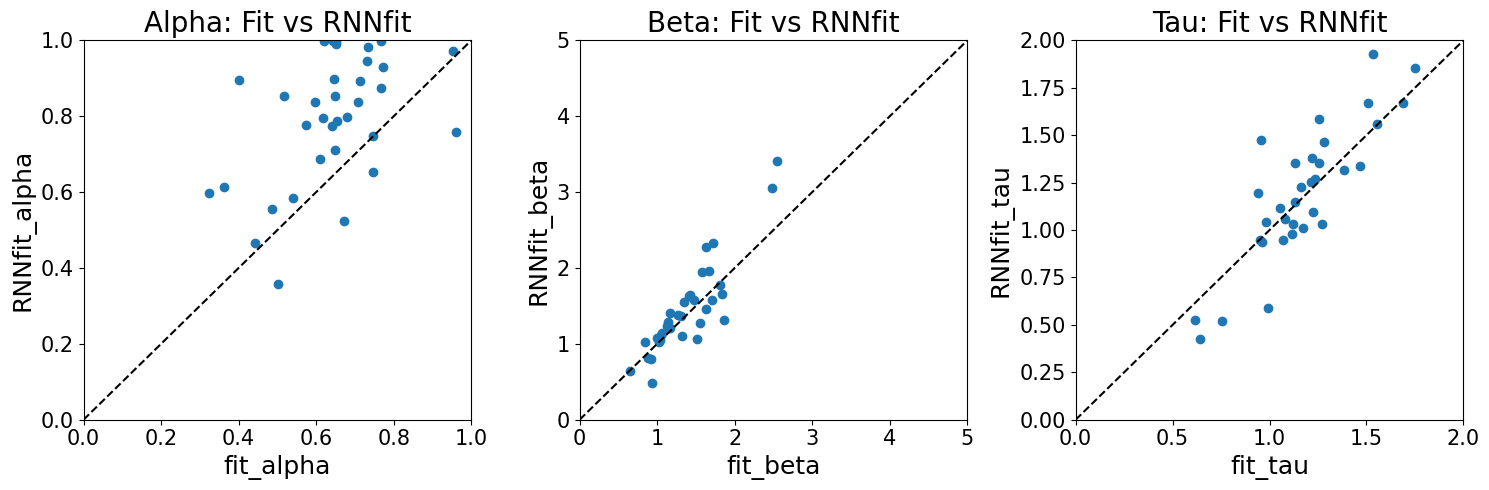

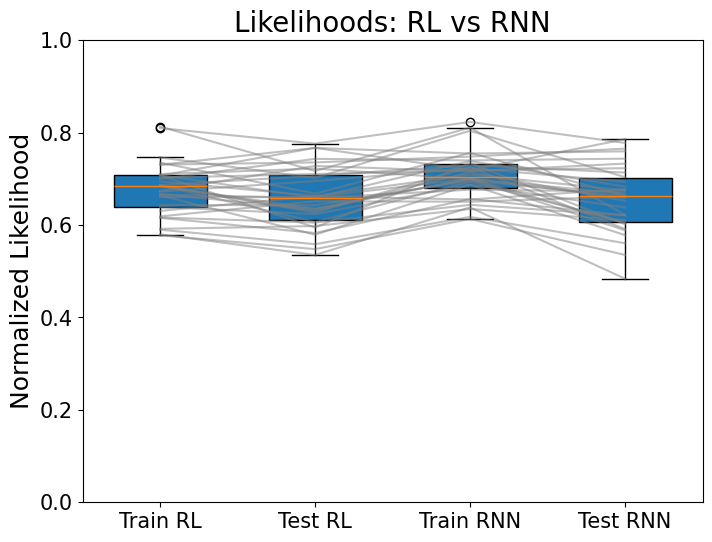

In [108]:
import matplotlib.pyplot as plt
import numpy as np

# Convert all_params to arrays for plotting
files = list(all_params.keys())
fit_alpha = np.array([all_params[f]['fit_alpha'] for f in files])
refit_alpha = np.array([all_params[f]['refit_alpha'] for f in files])
fit_beta = np.array([all_params[f]['fit_beta'] for f in files])
refit_beta = np.array([all_params[f]['refit_beta'] for f in files])

# Tau may not exist for all files
fit_tau = np.array([all_params[f].get('fit_tau', np.nan) for f in files])
refit_tau = np.array([all_params[f].get('refit_tau', np.nan) for f in files])

# Likelihoods
training_likelihood_RL = np.array([all_params[f]['training_likelihood_RL'] for f in files])
testing_likelihood_RL = np.array([all_params[f]['testing_likelihood_RL'] for f in files])
training_likelihood_RNN = np.array([all_params[f]['training_likelihood_RNN'] for f in files])
testing_likelihood_RNN = np.array([all_params[f]['testing_likelihood_RNN'] for f in files])

# Scatter plots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].scatter(fit_alpha, refit_alpha)
axs[0].plot([0, 1], [0, 1], 'k--')
axs[0].set_xlabel('fit_alpha')
axs[0].set_ylabel('RNNfit_alpha')
axs[0].set_title('Alpha: Fit vs RNNfit')
axs[0].set_xlim(0, 1)
axs[0].set_ylim(0, 1)

axs[1].scatter(fit_beta, refit_beta)
axs[1].plot([0, 5], [0, 5], 'k--')
axs[1].set_xlabel('fit_beta')
axs[1].set_ylabel('RNNfit_beta')
axs[1].set_title('Beta: Fit vs RNNfit')
axs[1].set_xlim(0, 5)
axs[1].set_ylim(0, 5)

if not np.all(np.isnan(fit_tau)):
    axs[2].scatter(fit_tau, refit_tau)
    axs[2].plot([0, 2], [0, 2], 'k--')
    axs[2].set_xlabel('fit_tau')
    axs[2].set_ylabel('RNNfit_tau')
    axs[2].set_title('Tau: Fit vs RNNfit')
    axs[2].set_xlim(0, 2)
    axs[2].set_ylim(0, 2)
else:
    axs[2].axis('off')
plt.tight_layout()
plt.show()

# Boxplot with lines connecting likelihoods
fig, ax = plt.subplots(figsize=(8, 6))
data = [training_likelihood_RL, testing_likelihood_RL, training_likelihood_RNN, testing_likelihood_RNN]
labels = ['Train RL', 'Test RL', 'Train RNN', 'Test RNN']
positions = np.arange(len(data))

# Boxplot
bp = ax.boxplot(data, positions=positions, widths=0.6, patch_artist=True)
ax.set_xticks(positions)
ax.set_xticklabels(labels)
ax.set_ylabel('Normalized Likelihood')

# Connect corresponding points with lines
for i in range(len(files)):
    ax.plot(positions, [training_likelihood_RL[i], testing_likelihood_RL[i], training_likelihood_RNN[i], testing_likelihood_RNN[i]], color='gray', alpha=0.5)
    ax.set_ylim(0, 1)
plt.title('Likelihoods: RL vs RNN')
plt.show()

Step 1000 of 1000; Loss: 1.7950e+03. (Time: 5.8s)

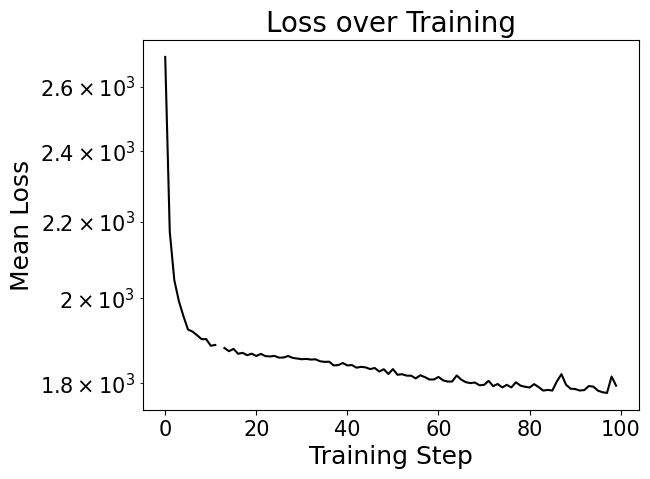

In [62]:
optimizer = optax.adam(learning_rate=1e-2)
disrnn_params, opt_state, losses = rnn_utils.train_model(
        model_fun = make_disrnn,
        dataset = dataset_train,
        optimizer = optimizer,
        loss_fun = 'penalized_categorical',
        penalty_scale=information_penalty,
        n_steps=n_steps,
        do_plot=True,
        truncate_seq_length=200,
    )